In [86]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_profiling as ppf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

# 数据的基本信息

In [87]:
root_path = Path('/media/bnu/data/deepshare-project/project1')
train_data_path = root_path / 'first_round_training_data.csv'
train_data = pd.read_csv(train_data_path)
train_data.head()

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,...,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Quality_label
0,0.001660,0.591013,147.608373,38.186345,0.000421,0.000612,2286.523413,0.035407,0.593081,1.010385,...,0.168761,1.098755,36.955992,8.454598,11.438066,177.243120,338.729256,2.021704,0.079526,Pass
1,1.601749,0.015052,0.035864,51.130326,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,...,11.649033,0.066671,225.632949,0.481860,20597.447822,3.723330,15.376190,0.986973,4.634376,Fail
2,0.098039,69.233685,0.080920,0.112265,0.000909,0.001972,2286.523413,0.035407,0.593081,1.010385,...,0.078213,110.079689,2.208138,0.073525,236.079314,0.064196,0.576302,33.875790,1.813727,Fail
3,18.181860,0.047325,0.018061,1.098102,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,...,0.380281,0.011491,0.654517,0.025872,176.948915,0.029777,0.246726,27.117165,0.081819,Fail
4,0.012085,0.008749,0.005509,524.327396,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,...,1.555672,38.613386,0.260989,0.009380,194.798039,0.055053,0.014725,13.569707,18.138496,Fail


In [88]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Parameter1     6000 non-null   float64
 1   Parameter2     6000 non-null   float64
 2   Parameter3     6000 non-null   float64
 3   Parameter4     6000 non-null   float64
 4   Parameter5     6000 non-null   float64
 5   Parameter6     6000 non-null   float64
 6   Parameter7     6000 non-null   float64
 7   Parameter8     6000 non-null   float64
 8   Parameter9     6000 non-null   float64
 9   Parameter10    6000 non-null   float64
 10  Attribute1     6000 non-null   float64
 11  Attribute2     6000 non-null   float64
 12  Attribute3     6000 non-null   float64
 13  Attribute4     6000 non-null   float64
 14  Attribute5     6000 non-null   float64
 15  Attribute6     6000 non-null   float64
 16  Attribute7     6000 non-null   float64
 17  Attribute8     6000 non-null   float64
 18  Attribut

从上面的信息可知，数据一共有6000条21列，没有空值。除了Quality_label列为object其余列数据类型都为float64

使用pandas-profiling查看数据并导出

In [35]:
profile = ppf.ProfileReport(train_data, title='Train Data Report', html={'style':{'full_width':True}})
profile.to_file(output_file='../reports/train_report.html')

# 数据离散性和连续性分析

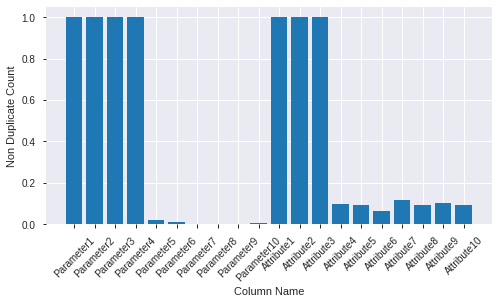

In [74]:
feature_columns = train_data.filter(regex='Parameter*|Attribute*').columns
non_duplicate_counts = []
for c in feature_columns:
    count = len(train_data[c].drop_duplicates()) / len(train_data)
    non_duplicate_counts.append(count)
    
plt.figure(figsize=(8, 4))
plt.bar(feature_columns, non_duplicate_counts)
plt.xlabel('Column Name')
plt.ylabel('Non Duplicate Count')
plt.xticks(rotation=45)
plt.show()

数据中Parameter4--Parameter9基本上是离散特征，Attribute4--Attribute10可能为离散特征，其余为连续特征

# 数据分布差异

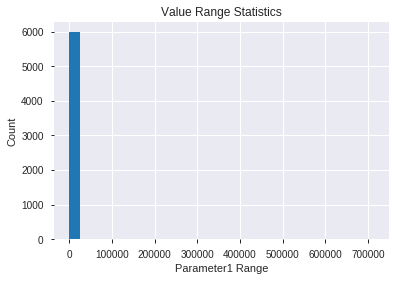

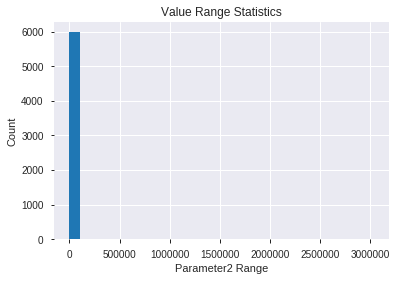

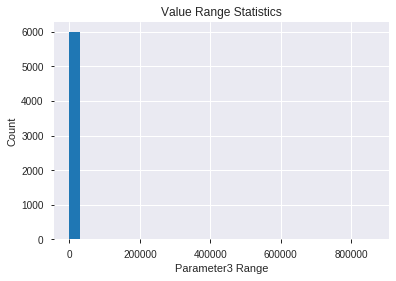

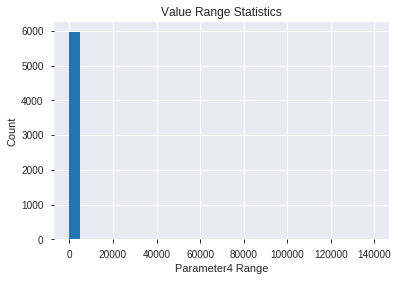

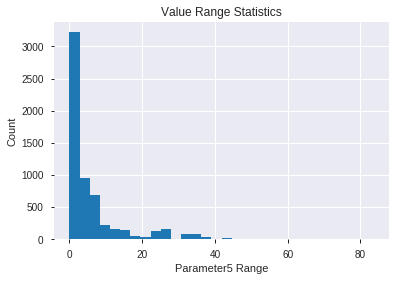

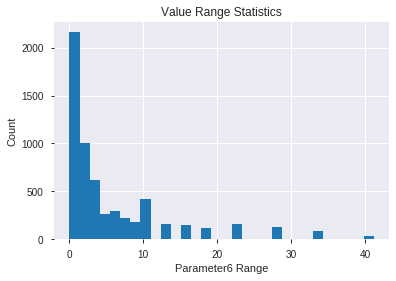

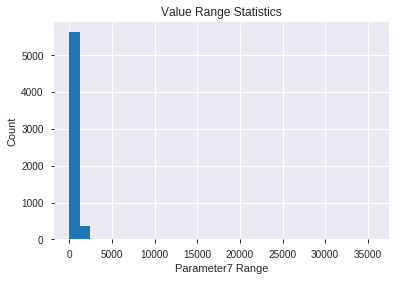

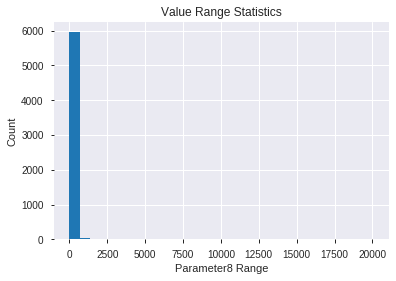

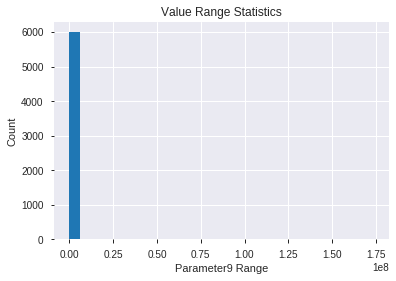

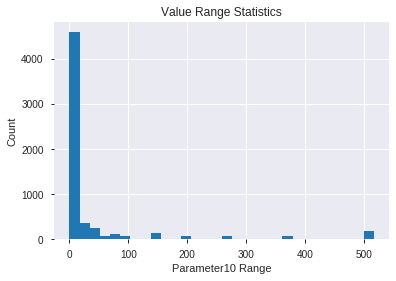

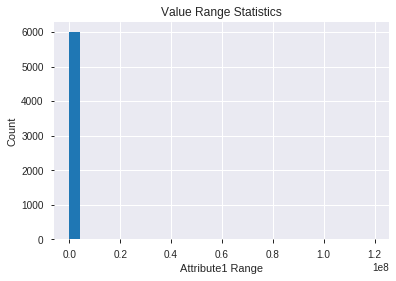

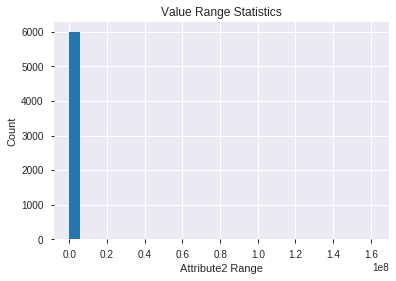

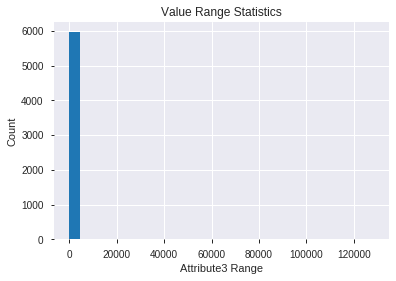

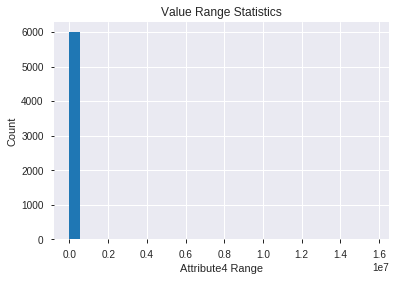

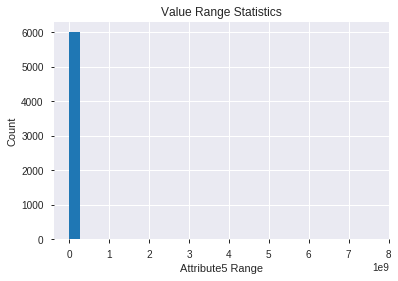

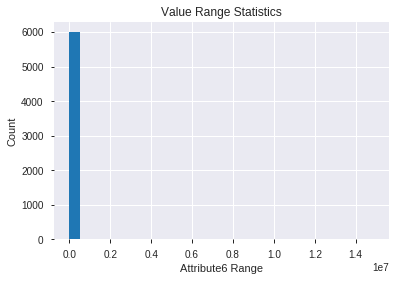

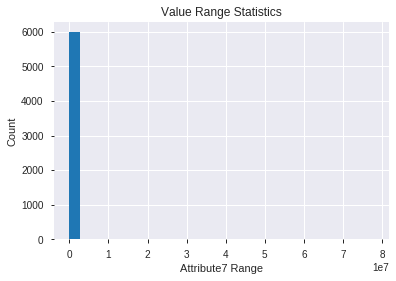

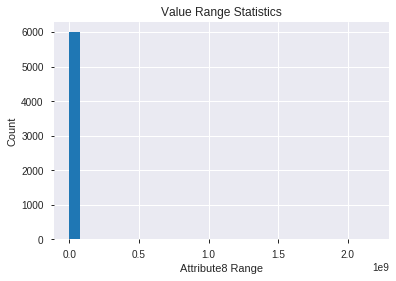

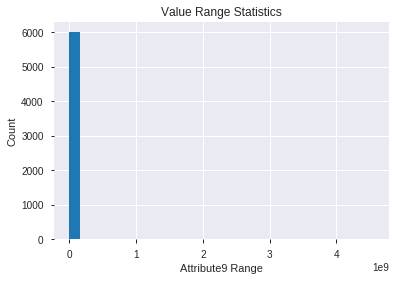

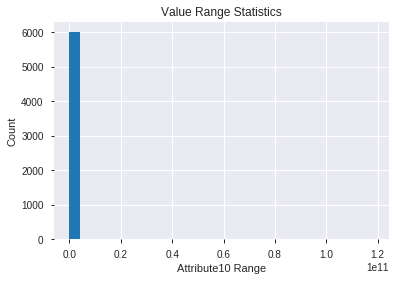

In [48]:
for c in feature_columns:
    plt.hist(train_data[c], bins=30)
    plt.title('Value Range Statistics')
    plt.xlabel(f'{c} Range')
    plt.ylabel('Count')
    plt.show()

从中可以看出大部分特征分布不均衡，需要对特征去偏

# 数据离散程度

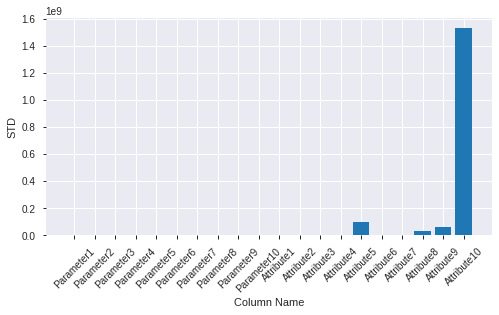

In [49]:
std_data = train_data[feature_columns].describe().T['std']
plt.figure(figsize=(8, 4))
plt.bar(feature_columns, std_data)
plt.xlabel('Column Name')
plt.ylabel('STD')
plt.xticks(rotation=45)
plt.show()

从中可以看出Attribute10标准差太高，应考虑取对数或开根号

# 数据标签处理

In [89]:
label_encoder = LabelEncoder()
train_data['Quality_label'] = label_encoder.fit_transform(train_data['Quality_label'])

In [90]:
train_data['Quality_label'].head()

0    3
1    1
2    1
3    1
4    1
Name: Quality_label, dtype: int64

# 数据去偏

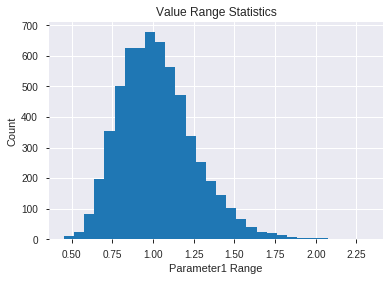

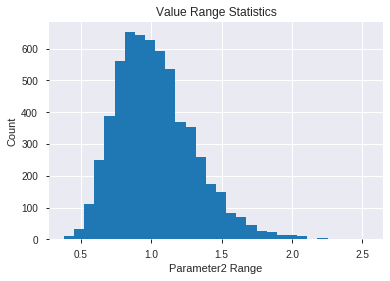

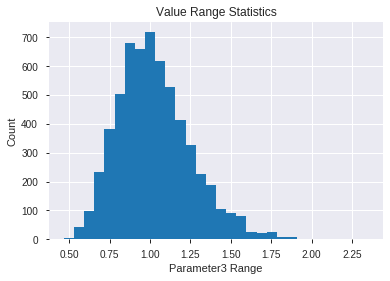

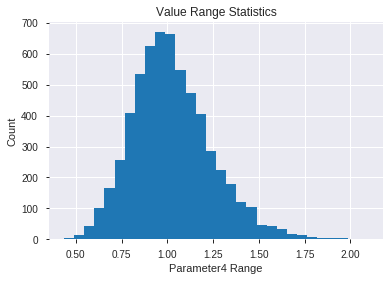

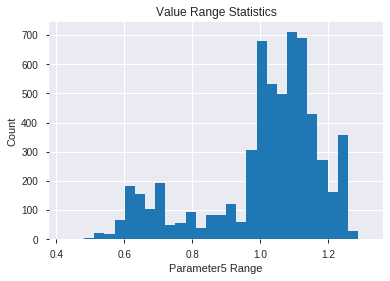

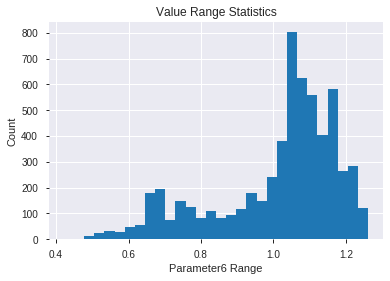

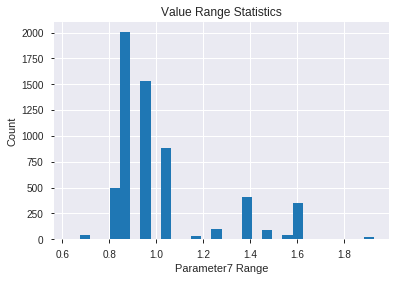

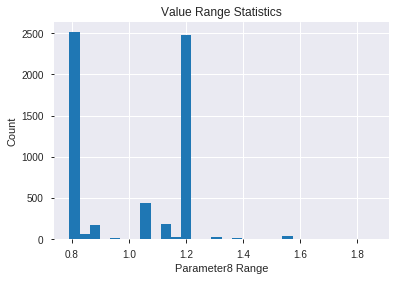

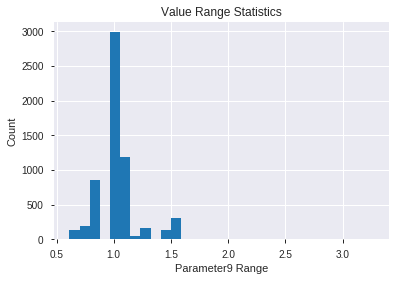

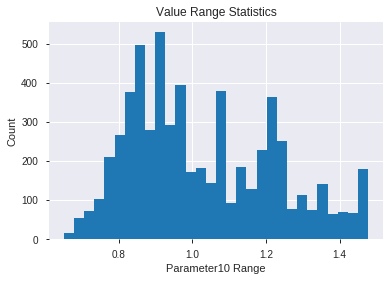

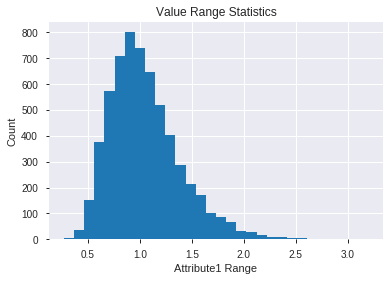

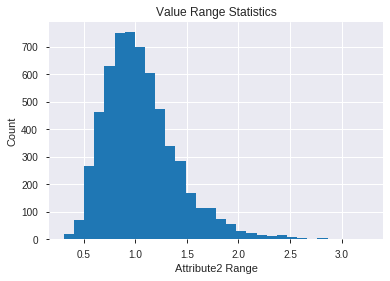

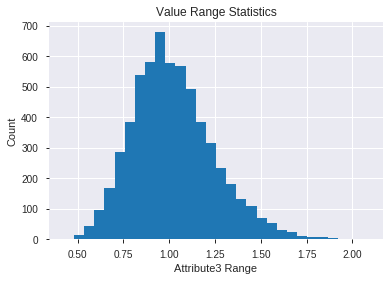

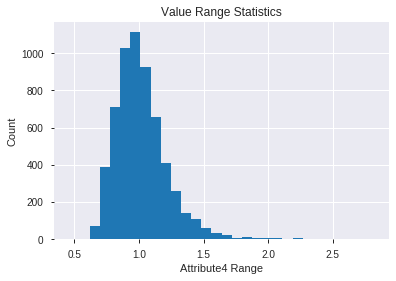

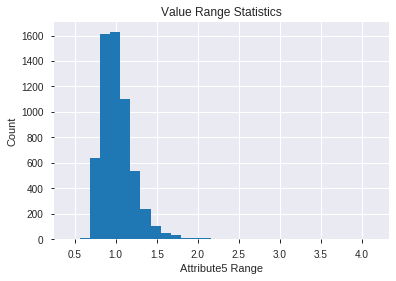

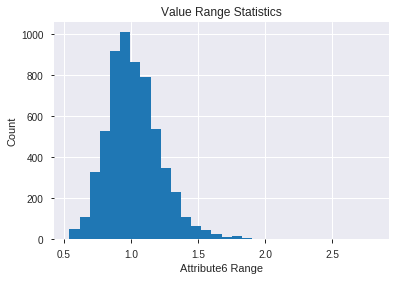

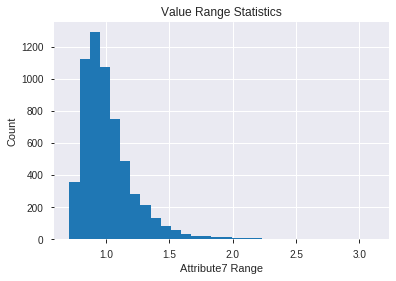

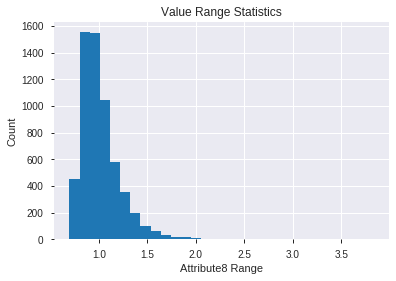

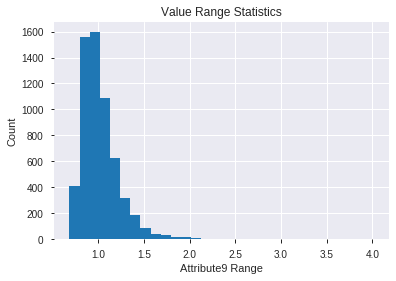

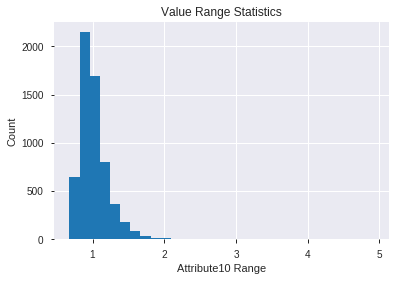

In [91]:
train_data[feature_columns] = train_data[feature_columns] ** (1 / 16)
for c in feature_columns:
    plt.hist(train_data[c], bins=30)
    plt.title('Value Range Statistics')
    plt.xlabel(f'{c} Range')
    plt.ylabel('Count')
    plt.show()

# 去除数据标准差

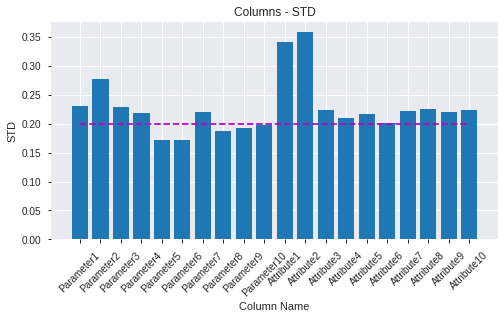

In [92]:
std_data = train_data[feature_columns].describe().T['std']
plt.figure(figsize=(8, 4))
plt.bar(feature_columns, std_data)
plt.plot(feature_columns, 0.2 * np.ones((20,)), c='m', linestyle="--")
plt.title('Columns - STD')
plt.xlabel('Column Name')
plt.ylabel('STD')
plt.xticks(rotation=45)
plt.show()

# 特征归一化

In [93]:
scaler = MinMaxScaler()
train_data[feature_columns] = scaler.fit_transform(train_data[feature_columns])

# 特征选择

In [94]:
select = SelectKBest(score_func=chi2, k=10)
select.fit(train_data[feature_columns], train_data['Quality_label'])
print(select.scores_)

[3.42647755e-02 5.88680824e-02 8.18672100e-02 1.60545454e-02
 2.00640514e+01 2.45479651e+01 1.09786956e+01 3.56619346e+01
 8.13572296e+00 1.17082327e+01 2.62618687e-01 1.49045334e-01
 4.63476234e-01 1.09052703e+02 3.99705747e+01 4.16673063e+01
 8.00541051e+01 5.77274675e+01 2.92513362e+01 1.14741229e+01]


In [95]:
train_data = pd.DataFrame(select.transform(train_data[feature_columns]),
                          columns=[f'v{i}' for i in range(10)])
train_data.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,0.215771,0.248177,0.018864,0.423379,0.335853,0.190725,0.274976,0.278901,0.236843,0.108023
1,0.249552,0.314923,0.018864,0.423379,0.399560,0.140250,0.582097,0.155419,0.156271,0.094268
2,0.249552,0.305036,0.018864,0.423379,0.249928,0.111712,0.382019,0.054066,0.086152,0.168483
3,0.249552,0.314923,0.018864,0.423379,0.217271,0.097248,0.370930,0.037619,0.070258,0.163313
4,0.249552,0.314923,0.018864,0.423379,0.194176,0.084073,0.374604,0.050713,0.023113,0.147681
